In [381]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


use_cuda=True
batch_size_train = 200
batch_size_test = 1
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import scipy.stats as stats

def psnr(x, x_test):
  mse = np.mean((np.reshape(x_test,[32,32])-np.reshape(x,[32,32]))**2)
  psnr = -100.0*np.log10(mse)
  return psnr

def entropy(x):
  return stats.entropy(x.flatten())

In [0]:
from torch.utils.data import random_split
#Give your own appropriate path if necessary
MNIST_training = torchvision.datasets.MNIST('/content/drive/My Drive/data/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(padding=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/content/drive/My Drive/data/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(padding=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])

train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=False)

In [384]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
            

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model from google drive
model.load_state_dict(torch.load('/content/drive/My Drive/data/MNIST_LeNet_results/model.pth'))
# OR Load the pretrained model directly if you upload the model inside Files
# model.load_state_dict(torch.load('model.pth'))
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
# FGSM attack code
# reference : https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack2(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon*sign_data_grad 
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1) 
    # Return the perturbed image
    return perturbed_image

In [0]:
# FGSM attack code
# reference : https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack1(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad 
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1) 
    # Return the perturbed image
    return perturbed_image

True

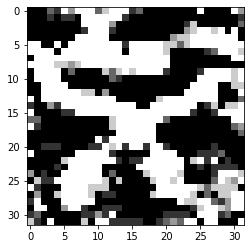

In [387]:
# Question 1
import cv2
random_img = torch.randint(255, size=(1,1,32,32)).to(dtype=torch.float32).to(device)
random_img.requires_grad = True
label = torch.tensor([0]).to(device)
model.zero_grad()

for i in range(200):
  output = model(random_img)
  loss = F.nll_loss(output, label)
  model.zero_grad()
  loss.backward()
  data_grad = random_img.grad.data
  random_img = fgsm_attack1(random_img, 0.2, data_grad)

  random_img.detach_()
  random_img.requires_grad_(True)

image1 = (random_img * 255.0).squeeze().detach().cpu().numpy()
plt.imshow(image1, cmap="gray")
cv2.imwrite('Image1.jpg',image1)

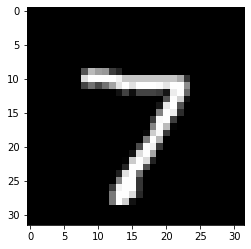

True

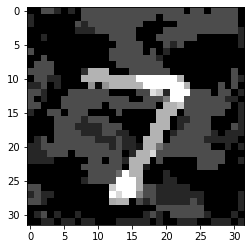

In [388]:
# Question 2
examples = enumerate(test_loader)
_, (example_data, _) = next(examples)
data = example_data
plt.imshow(data.squeeze().numpy(), cmap="gray")
plt.show()

img = data.to(device)
label = torch.tensor([0]).to(device)
img.requires_grad = True
model.zero_grad()

for i in range(3):
  output = model(img)
  loss = F.nll_loss(output, label)
  model.zero_grad()
  loss.backward()
  data_grad = img.grad.data
  img = fgsm_attack2(img, 0.15, data_grad)

  img.detach_()
  img.requires_grad_(True)

image2 = (img * 255.0).squeeze().detach().cpu().numpy()
plt.imshow(image2, cmap="gray")
cv2.imwrite('Image2.jpg', image2)

In [389]:
import matplotlib.pyplot
import cv2

def main():
  
  entropy_min_thres1 = 6.0
  prob_min_thres1 = 0.7
  prob_max_thres1 = 0.8
  
  fake_label2 = 0
  psnr_min_thres2 = 25
  psnr_max_thres2 = 28
  
  image1 = matplotlib.pyplot.imread('Image1.jpg')
  image2 = matplotlib.pyplot.imread('Image2.jpg')

  
  image1 = image1.reshape((1, 1, 32, 32)) / 255.0
  image2 = image2.reshape((1, 1, 32, 32)) / 255.0
  tensor1 = torch.tensor(image1, dtype=torch.float32).to(device)
  tensor2 = torch.tensor(image2, dtype=torch.float32).to(device)
  
  
  # score 1st question
  output = torch.exp(model(tensor1))
  output_np = output.detach().cpu().numpy()
  max_prob1 = np.amax(output_np)
  entropy1 = entropy(image1)
  score1 = (max_prob1 - prob_min_thres1) / (prob_max_thres1 - prob_min_thres1)
  score1 = np.clip(score1, 0, 1)
  score1 = score1 if entropy1 > entropy_min_thres1 else 0
  
 
  # score 2nd question
  for xb, yb in test_loader: 
    break #just once
  test_data= xb.cpu().numpy() 
  
  output = model(tensor2)
  init_pred = output.max(1, keepdim=True)[1]
  label2 = init_pred.item()
  #print(xb.shape, image2.shape)
  psnr2 = psnr(test_data, image2)
  score2 = (psnr2 - psnr_min_thres2) / (psnr_max_thres2 - psnr_min_thres2)
  score2 = np.clip(score2, 0, 1)
  score2 = score2 if label2 == fake_label2 else 0


  total_score = score1 * 0.5 + score2 * 0.5
  assignment_score = total_score * 75
    
  result = (f"Student Name= Zijun Wu, Student id: 1488834\n"
            f"question 1:\tentropy={entropy1}\tmax_prob={max_prob1}\tscore={score1}\n"
            f"question 2:\tpsnr={psnr2}\t\tlabel={label2}\t\tscore={score2}\n"
            f"total_score={total_score}\n"
            f"assignment_coding_score={assignment_score:.2f}, out of 75.00")
  print("result:")
  print(result)
  
  with open('result.txt', 'w') as f:
    f.writelines(result)

main()

result:
Student Name= Zijun Wu, Student id: 1488834
question 1:	entropy=6.263114823087692	max_prob=0.9974274635314941	score=1.0
question 2:	psnr=30.633933560282955		label=0		score=1.0
total_score=1.0
assignment_coding_score=75.00, out of 75.00
